
# Using a Machine Learning Model to Predict Medical Appointment No-shows
**WGU BS Data Management/Data Analytics Capstone**

Amanda F. Bowman

March 2024


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#sample">Sample</a></li>
<li><a href="#explore">Explore</a></li>
<li><a href="#modify">Modify</a></li>
<li><a href="#model">Model</a></li> 
<li><a href="#assess">Assess</a></li> 
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>

<a id='intro'></a>
## Introduction

Appointment no-shows have a significant negative impact across the board. An appointment no-show is when a patient fails to “show-up,” or attend, their scheduled appointment. Typically, a no-show is defined as the patient not attending their appointment without notice. More and more frequently, no-shows are defined as not attending with either no notice or less than 24 hours notice. It is important to understand that when a patient is said to have no-showed for their appointment (where no-show = Yes), it means that the patient did not attend.

No-showing for appointments negatively impacts patient outcomes as it increases the likelihood of attrition and means the patient may not be getting the monitoring they need for whatever conditions they have (Marbough et al., 2020). It negatively impacts health systems both financially, in terms of lost revenue and increased costs when patients subsequently need more care, and functionally, in terms of the negative impact to provider and staff well-beig . Reducing appointment no-shows can improve these outcomes (Oikonomidi et al. 2022).

Studies have shown that using predictive models to identify patients at risk of no-showing can be effective. Additional research is being performed using predictive models to determine what interventions may be most effective. Some researchers have found that making no-show predictive models generalizable is challenging, even between specialties within the same healthcare system (Xirou, 2018). This can be because of many factors including different patient characteristics and different issues impacting the patients. For example, the factors that impact a pediatric primary care clinic are likely to be very different from those of an adult cardiology clinic. 

This project analyzes medical appointment no-show data with the goal of developing a supervised machine learning model that could be used to predict future appointment no-shows.

### Data Set Description
One of the difficulties of analyzing medical patient data is obtaining de-identified data that can be used and published. Many of the studies I reviewed in preparation for this project noted that their data was not available for public analysis. As a result, I use a publicly available sample data set. The data set selected for this project consisted of one CSV file downloaded from the Medical Appointment No Shows data set on Kaggle (Hoppen, 2016). The Brazilian data set contains data for 110,527 unique appointments with associated values for 14 different characteristics. It was most recently updated seven years ago and collected by Joni Hoppen in collaboration with Aquarela Analytic . One item of note when viewing this dataset is that the value of the No Show column indicates whether the patient no-showed for the appointment. This means that "Yes" or, later, True mean that the patient did NOT attend the appointment.

#### Descriptive information about each column

| Column Name     | Description   | Original Datatype |
|:-----           |:-----         |:-------           |
|PatientId      |Identification of a patient   | float             |
| AppointmentID  | Identification of each appointment         | int               |
| Gender         | Male or Female .    | string            |
| ScheduledDay   | The day someone called or registered the appointment, this should be before appointment.      | string            |
| AppointmentDay | The day of the actual appointment, when they have to visit the doctor.                                                                                                                                                 | string            |
| Age            | How old is the patient.                                                | int               |
| Neighbourhood  | Where the appointment takes place.                                                 | string            |
| Scholarship    | 0 or 1 .  True indicates enrollment in the social program Bolsa Familia. Between 2003 and 2021, Bolsa Familia supported families with children ages 0-17 living in poverty (monthly income between R$85.01 and R$170.00) and in extreme poverty  (monthly income equal to or less than R$85.00).  Note: To maintain eligibility, children must receive vaccinations on schedule and maintain attendance in school. For children between the ages of 6 and 15, they must meet a 85\%   attendance expectation. Children aged between 16 and 17  must meet a 75\% attendance expectation.  | int               |
| Hipertension   |0 or 1     | int               |
| Diabetes       | 0 or 1     | int               |
| Alcoholism     | 0 or 1     | int               |
| Handcap        | 0-4    | int               |
| SMS_received   | 0 or 1 | int               |
| No-show        | Yes or No. Yes means patient no-showed for the appointment.      | string           

[Download the Data](https://www.kaggle.com/datasets/joniarroba/noshowappointments) |

### Import the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

%matplotlib inline


Additional packages that were used but are not part of the final analysis:

from sklearn.feature_selection import RFECV

from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import InstanceHardnessThreshold

from sklearn.model_selection import GridSearchCV


<a id='sample'></a>
## Sample
### Objective 1: Gather Data
Load the csv

In [2]:
# Load data and print out a few lines to get a basic understanding of the dataset and ensure loading:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


<a id='explore'></a>
## Explore

### Objective 2: Explore the original data 

#### Visual Assessment

In [3]:
# Show head for a visual assessment
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Programmatic Assessment

In [4]:
# Understand basic features of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# View statistical information about the numerical columns
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
# While several of these columns are integers, they appear to represent categorical data. 
# What are the possible values?
original_columns = ['Gender','Neighbourhood', 'Scholarship', 'Hipertension', 
                    'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for col in original_columns:
    col_values = str(col) + ': ' + str(pd.unique(df[col])) 
    print(col_values) 
    print()  # cycle through each column and print the concatenated string

Gender: ['F' 'M']

Neighbourhood: ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'IL

In [7]:
# Number of duplicate rows?
sum(df.duplicated())

0

In [8]:
# Missing values?
df.isna().any(axis=1).sum() 

0

In [9]:
# Check the number of unique patients versus the number of unique appointments to determine how these columns relate
print('Number of unique patients: ', df['PatientId'].nunique())
print('Number of unique appointments: ', df['AppointmentID'].nunique())

Number of unique patients:  62299
Number of unique appointments:  110527


This indicates that each appointment is only linked to one patient, but one patient can have many appointments.

#### Visualizations of Initial Data

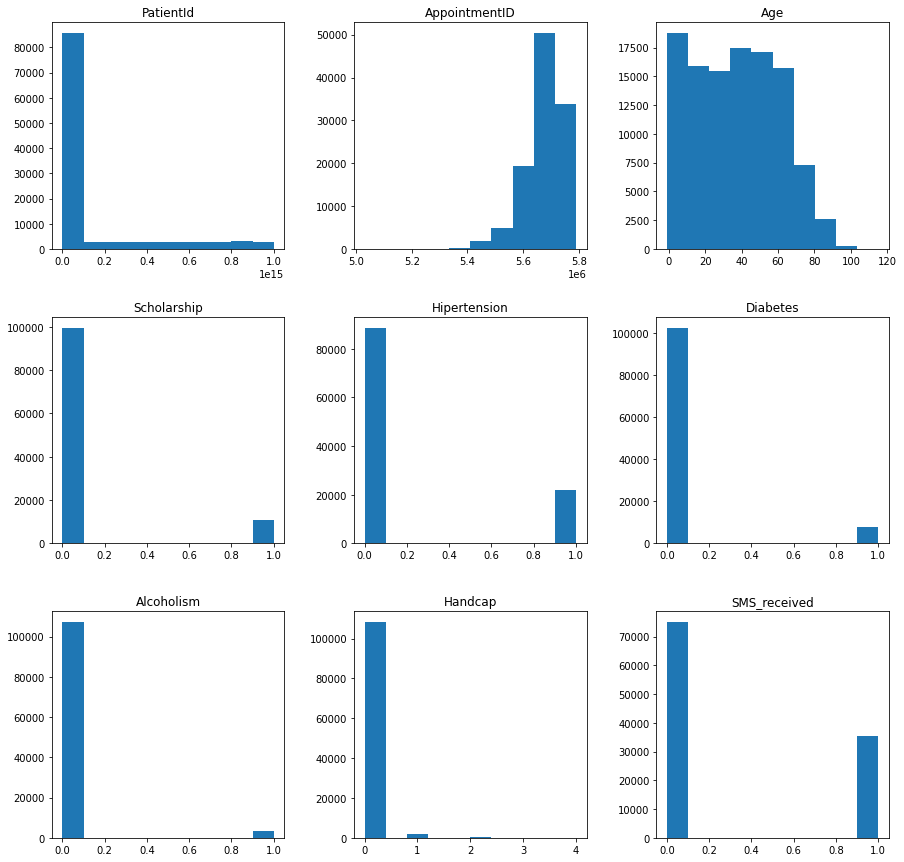

In [10]:
# Histograms of each column to better understand the data and distributions for each column 
# AppointmentID and PatientId will have no meaning.
df.hist(figsize=(15,15), grid=False);

In [11]:
# Set plotting size variables
fig_dims = (12,5)
plot_height = 5
plot_aspect = 11.7/5

# Define plotting functions for use throughout the notebook
def plot_dist(df, col_name, width_bin):
    """Plots a distribution of the given column name with the defined bin widths"""
    sns.displot(data=df, x=col_name, binwidth=width_bin, height=plot_height, aspect=plot_aspect);
    plt.title(f'Distribution of Values for {col_name}')

def plot_noshow_compare(df, col_name):
    """Plots a histogram of the given original column values broken down by No-show value"""
    g = sns.displot(data=df, 
                    x=col_name, 
                    kind='hist', 
                    hue='No-show', 
                    height=plot_height, 
                    aspect=plot_aspect, 
                    multiple='stack');
    g.fig.suptitle(f'Distribution of {col_name} by No-shows', y=1.03)
    return g

In [12]:
# List of column names
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

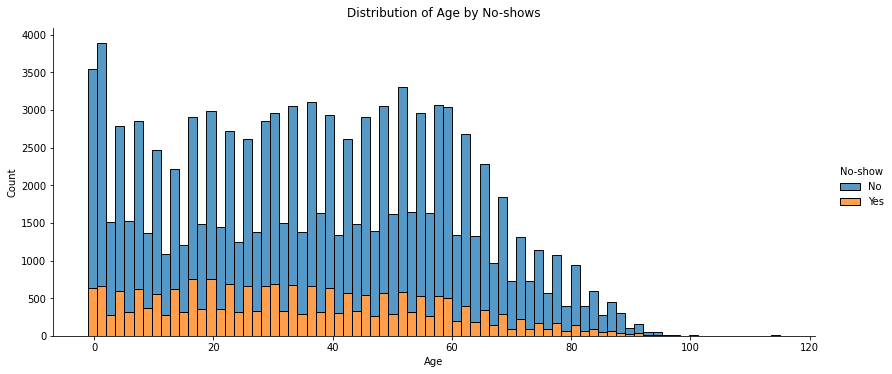

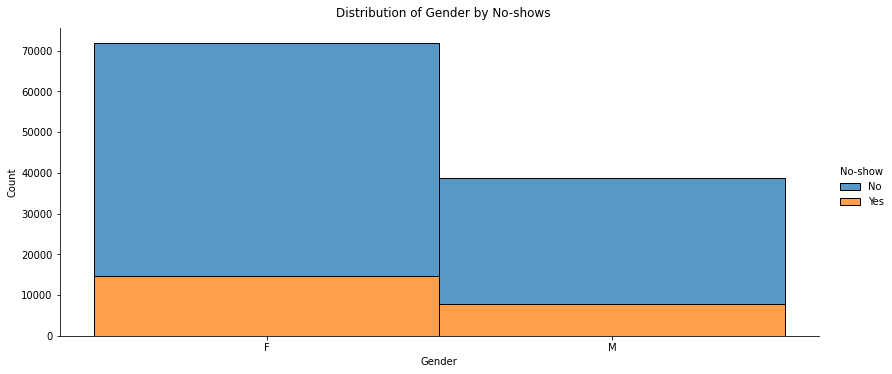

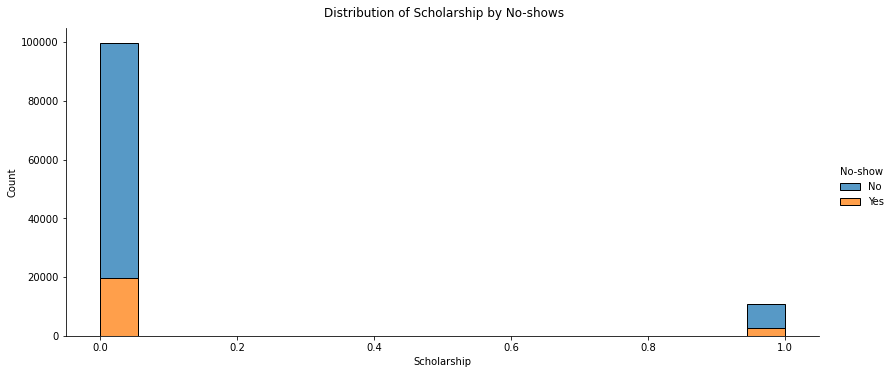

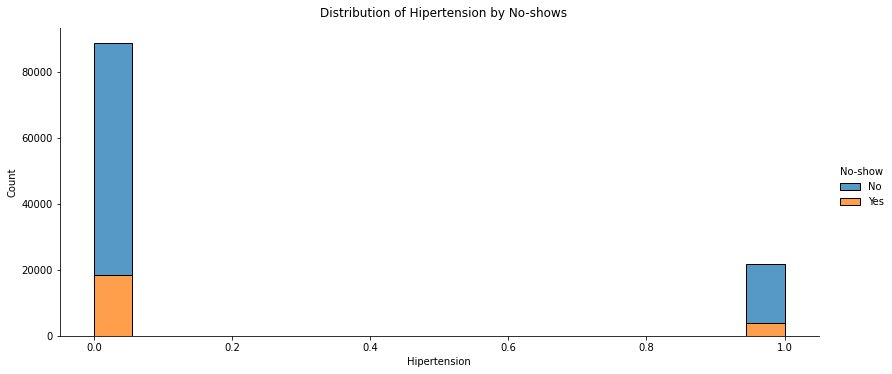

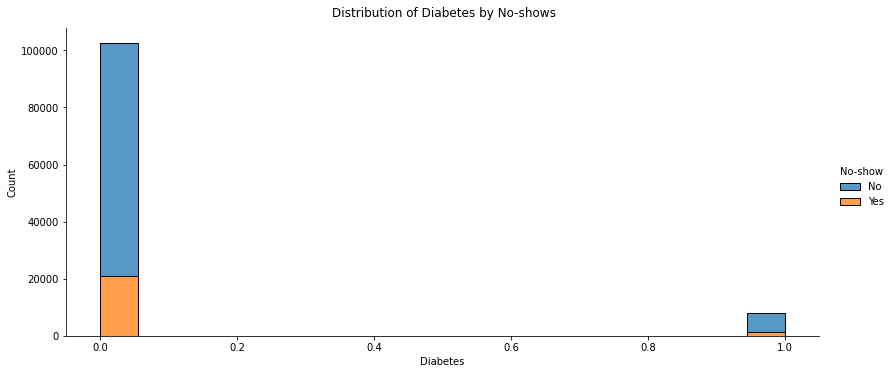

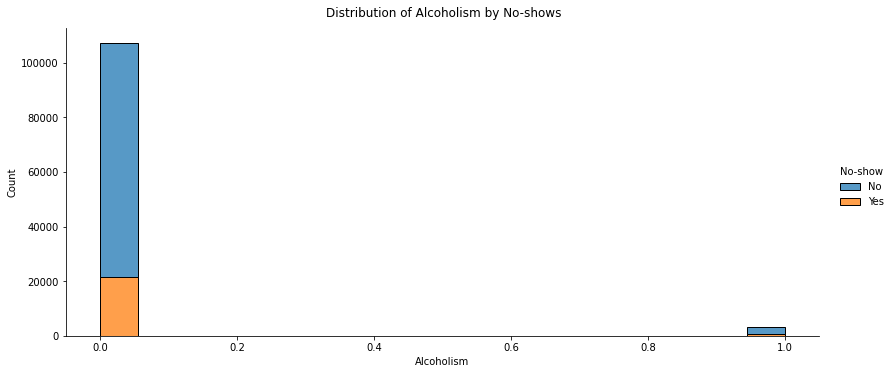

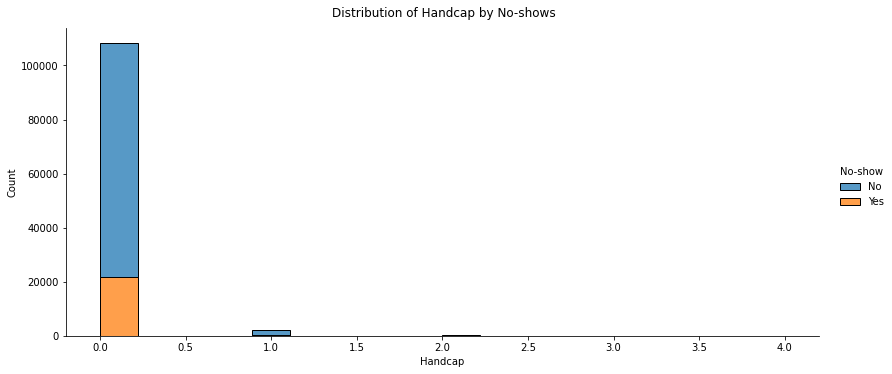

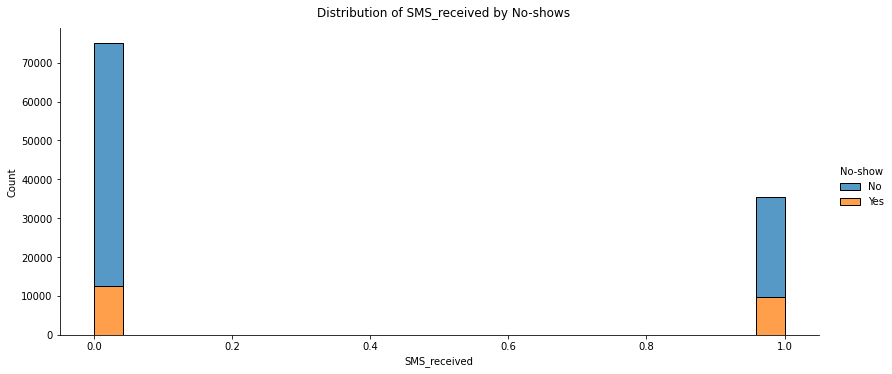

In [13]:
# Define columns with data that can be compared to no-shows
cols_to_compare = ['Age', 'Gender', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

# Plot histograms of each column with comparison of no-shows
for col_to_compare in cols_to_compare:
    plot_noshow_compare(df, col_to_compare)

In [14]:
no_props = len(df[df['No-show'] == 'No']) / df.shape[0]
yes_props = len(df[df['No-show'] == 'Yes']) / df.shape[0]

Proportion of No for No Show Column: 0.798067440534892
Proportion of Yes for No Show Column: 0.20193255946510807


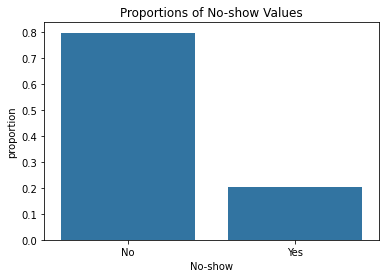

In [15]:
# Plot distribution of no-show appointments
print('Proportion of No for No Show Column: {}'.format(no_props))
print('Proportion of Yes for No Show Column: {}'.format(yes_props))
sns.countplot(data=df, x='No-show', stat='proportion');
plt.title('Proportions of No-show Values');

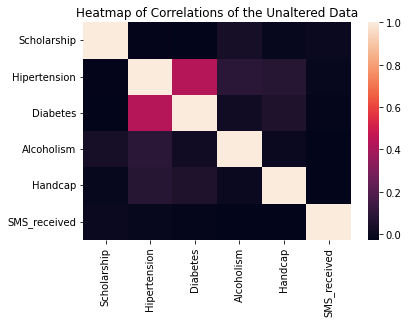

In [16]:
# Review initial correlations - note no-show isn't included here as it is still a string column
sns.heatmap(df[original_columns].corr());
plt.title('Heatmap of Correlations of the Unaltered Data');

### Quality and Tidiness Issues and Plan

* `ScheduledDay` and `AppointmentDay` are objects and need to be converted to datetime. Additional feature engineering will need to be performed to obtain value from these columns. For example, evaluation of the number of days between the scheduling date and the appointment date or the weekday.
* `PatientId` and `AppointmentID` are identification rather than continuous numerical values. They will need to be dropped prior to modeling.
* `Gender`, `Neighbourhood`, and `No-show` are categorical strings that will need to be made numerical.
* `Age` will need to be further assessed for erroneous data as there are patients aged less than 0 and there appear to be outliers close to age 120 years.
* While there are no duplicate appointments, there are duplicate patients. Past research shows that prior appointment no-show rate can be predictive of future no-show appointments. Feature engineering will need to be performed to capture this.
* As expected based on reviews of research articles, there is a substantial class imbalance between no-show values. There is also substantial skew in the categorical columns.

* Column names need to be made all lower case and separated with _


<a id='modify'></a>
## Modify

### Objective 3: Prepare the data for modeling


As identified above, there are no duplicate rows and no missing values. My data will require some wrangling before it is ready for use in a model. I will address some general issues and perform initial feature engineering on the date columns.

#### Clean Basic Issues in the Dataset

 
 * Column Headers:
     - Capitalized - need to make lower case
     - Need to separate PatientId, AppointmentID, ScheduledDay, AppointmentDay with _
     - Change No-show to no_show     
     - Update Hipertension and Handcap column names
     
* Data types:
     - sheduled_day and appointment_day to datetime

* Address Outliers in Age
 
Appointment and Patient ID will be dropped later due to the need to use them for Feature Engineering

     


In [17]:
# Make a copy of the data
df_prep = df.copy()

In [18]:
# Make all column names lower case and replace the dash with an underscore
df_prep.rename(columns= lambda x:x.lower().replace("-", "_"), inplace=True)
# Rename the rest of columns by adding an underscore and update column names 
df_prep.rename(columns={'scheduledday':'scheduled_day', 'appointmentday':'appointment_day', 'hipertension':'hypertension', 'handcap':'disability_count', 'patientid': 'pt_id', 'appointmentid': 'appt_id'}, inplace=True)
# Check new column names
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pt_id             110527 non-null  float64
 1   appt_id           110527 non-null  int64  
 2   gender            110527 non-null  object 
 3   scheduled_day     110527 non-null  object 
 4   appointment_day   110527 non-null  object 
 5   age               110527 non-null  int64  
 6   neighbourhood     110527 non-null  object 
 7   scholarship       110527 non-null  int64  
 8   hypertension      110527 non-null  int64  
 9   diabetes          110527 non-null  int64  
 10  alcoholism        110527 non-null  int64  
 11  disability_count  110527 non-null  int64  
 12  sms_received      110527 non-null  int64  
 13  no_show           110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [19]:
# Convert date columns to DateTime
df_prep['scheduled_day'] = pd.to_datetime(df_prep['scheduled_day'])
df_prep['appointment_day'] = pd.to_datetime(df_prep['appointment_day'])
df_prep.head()

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Address Age Outliers
 
 Age is an integer variable starting at 0. There were patients aged under 0 and over 100 years old. 115 years old seems like a potential error.

The number of patients between the ages of 100 and 120 is very small. What can I learn about those patients to determine whether they need to be dropped from the data set as errors?

What are the ages of the patient for the 10 oldest-aged appointments?

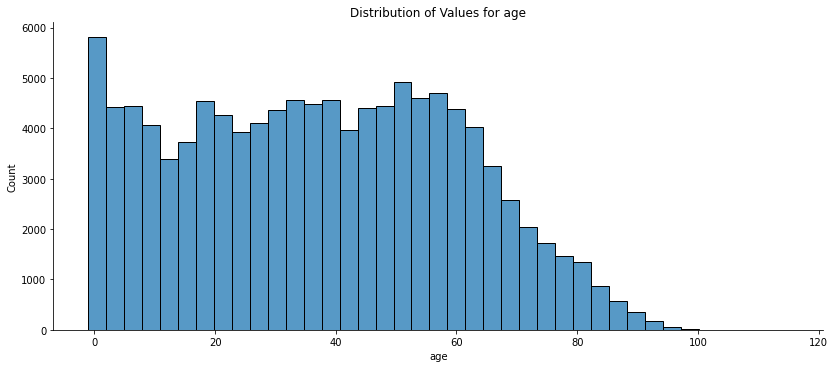

In [20]:
# What does the distribution of ages look like?
plot_dist(df_prep,'age', 3)

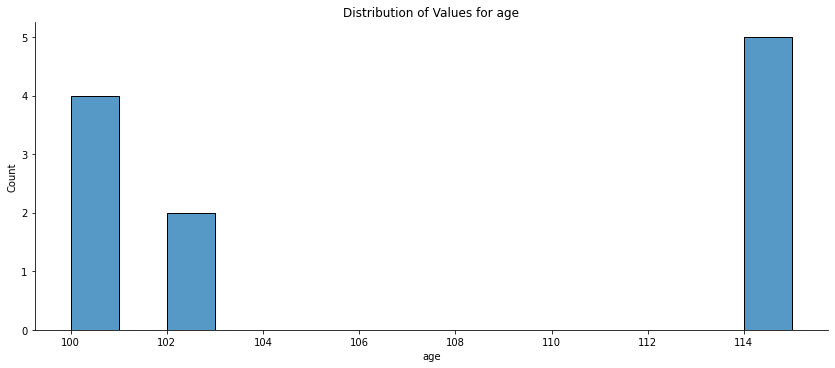

In [21]:
#The number of patients between the ages of 100 and 120 is very small. 
# What can I learn about those patients to determine whether they need to be dropped from the data set as errors?
plot_dist(df_prep[df_prep['age'] >= 100], 'age', 1)

In [22]:
# Appointment rows for patients 102 years
df_prep[df_prep['age'] >= 102]

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
58014,9.762948e+14,5651757,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,No


Based on patient ID, the max age of 115 is for two distinct patients, one with multiple appointments. The next oldest is 102. While it is possible that this age is correct, reviewing [World Age Statistics] (https://en.wikipedia.org/wiki/Oldest_people#:~:text=The%20oldest%20living%20person%20in,Venezuela%2C%20born%2027%20May%201909.) indicates it is unlikely to have even one person of this age in this data, let alone two. It is impossible to determine whether these ages were entered in error, so it will be necessary to remove these rows. Since the next oldest patient is 102 and there are 6 patients between the ages of 100 and 102, I will use this as a cutoff. 

In [23]:
# Drop outliers - patients older than 102 and with negative values
df_prep.drop(df_prep[df_prep['age'] > 102].index, inplace = True)
df_prep.drop(df_prep[df_prep['age'] < 0].index, inplace = True)

In [24]:
# Check new descriptive statistics
df_prep['age'].describe()

count    110521.000000
mean         37.085694
std          23.104606
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: age, dtype: float64

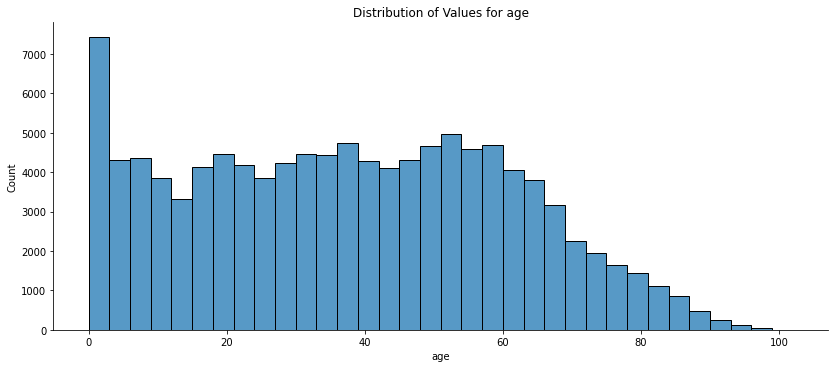

In [25]:
# Plot new distribution
plot_dist(df_prep,'age', 3)

### Feature Engineering and Encoding

#### No Show Rate Feature Engineering
 
While every appointment id is unique, there are duplicate rows for some patients. This means that some patients may have multiple no-shows. Literature shows that past No Shows can be a good indicator of future now shows. As such, it would be helpful to calculate the no show rate for each patient.

 * Create a function to add columns for the number of past appointments and past no-shows the patient has had.
 * Calculate the past no-show rate for each appointment
 * Drop the past appointment and no-show columns, as those features are included as a part of the no-show rate.

In [26]:
# View head following basic cleaning
df_prep.head()

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [27]:
# Number of appointments for patients with more than one appointment
sum(df_prep['pt_id'].duplicated(keep=False))

72603

In [28]:
# Define function to count number of past appointments and no-shows
def count_noshows(dup_df):
    """Adds columns with cumulative count of appointments and no-shows for each patient.
    
    Parameters:
    dup_df: DataFrame of patients
    
    Returns:
    dup_df: same DataFrame with new columns for appointment and no-show count
    """
    # sort df first by patient id and then by appointment date
    dup_df = dup_df.sort_values(['pt_id', 'appointment_day'])
    
    # group rows by patient id and cumulatively count the number of appointments
    dup_df['past_appts'] = dup_df.groupby('pt_id').cumcount()

    # group rows by patient id and counts the number of no shows for each row
    dup_df['past_ns'] = (dup_df
                          .groupby('pt_id')['no_show']
                          .apply(lambda x: (x == 'Yes')
                          .cumsum() - (x == 'Yes').astype(int))).fillna(0)
    return dup_df

In [29]:
# Apply function to the df
df_prep = count_noshows(df_prep)

In [30]:
# Review updated info
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 100517 to 76224
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   pt_id             110521 non-null  float64            
 1   appt_id           110521 non-null  int64              
 2   gender            110521 non-null  object             
 3   scheduled_day     110521 non-null  datetime64[ns, UTC]
 4   appointment_day   110521 non-null  datetime64[ns, UTC]
 5   age               110521 non-null  int64              
 6   neighbourhood     110521 non-null  object             
 7   scholarship       110521 non-null  int64              
 8   hypertension      110521 non-null  int64              
 9   diabetes          110521 non-null  int64              
 10  alcoholism        110521 non-null  int64              
 11  disability_count  110521 non-null  int64              
 12  sms_received      110521 non-null  int64

In [31]:
# View updated DataFrame
df_prep.sort_values('pt_id').head(20)

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,past_appts,past_ns
100517,3.921784e+04,5751990,F,2016-05-31 10:56:41+00:00,2016-06-03 00:00:00+00:00,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0,0
105430,4.374176e+04,5760144,M,2016-06-01 14:22:58+00:00,2016-06-01 00:00:00+00:00,39,MARIA ORTIZ,0,0,1,0,0,0,No,0,0
3950,9.377953e+04,5712759,F,2016-05-18 09:12:29+00:00,2016-05-18 00:00:00+00:00,33,CENTRO,0,0,0,0,0,0,No,0,0
73303,1.417242e+05,5637648,M,2016-04-29 07:13:36+00:00,2016-05-02 00:00:00+00:00,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0,0
73228,5.376153e+05,5637728,F,2016-04-29 07:19:57+00:00,2016-05-06 00:00:00+00:00,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0,0
54611,5.628261e+06,5680449,M,2016-05-10 11:58:18+00:00,2016-05-13 00:00:00+00:00,13,PARQUE MOSCOSO,0,0,0,0,0,0,Yes,0,0
40692,1.183186e+07,5718578,M,2016-05-19 09:42:07+00:00,2016-05-19 00:00:00+00:00,16,SANTO ANTÔNIO,0,0,0,0,0,0,No,0,0
58616,2.263866e+07,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,0,0
88585,2.263866e+07,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,1,0
83628,5.216894e+07,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,0,0


In [32]:
# Calculate new column with no-show rate
df_prep['noshow_rate'] = (df_prep['past_ns'] / df_prep['past_appts']).fillna(0)
df_prep.head(10)

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,past_appts,past_ns,noshow_rate
100517,3.921784e+04,5751990,F,2016-05-31 10:56:41+00:00,2016-06-03 00:00:00+00:00,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0,0,0.0
105430,4.374176e+04,5760144,M,2016-06-01 14:22:58+00:00,2016-06-01 00:00:00+00:00,39,MARIA ORTIZ,0,0,1,0,0,0,No,0,0,0.0
3950,9.377953e+04,5712759,F,2016-05-18 09:12:29+00:00,2016-05-18 00:00:00+00:00,33,CENTRO,0,0,0,0,0,0,No,0,0,0.0
73303,1.417242e+05,5637648,M,2016-04-29 07:13:36+00:00,2016-05-02 00:00:00+00:00,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0,0,0.0
73228,5.376153e+05,5637728,F,2016-04-29 07:19:57+00:00,2016-05-06 00:00:00+00:00,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0,0,0.0
54611,5.628261e+06,5680449,M,2016-05-10 11:58:18+00:00,2016-05-13 00:00:00+00:00,13,PARQUE MOSCOSO,0,0,0,0,0,0,Yes,0,0,0.0
40692,1.183186e+07,5718578,M,2016-05-19 09:42:07+00:00,2016-05-19 00:00:00+00:00,16,SANTO ANTÔNIO,0,0,0,0,0,0,No,0,0,0.0
58616,2.263866e+07,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,0,0,0.0
88585,2.263866e+07,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,1,0,0.0
83628,5.216894e+07,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,0,0,0.0


In [33]:
# Review duplicate patients in df to make sure no-show rate was calculated appropriately
df_prep[df_prep['pt_id'].duplicated(keep=False)].sort_values('pt_id').head(10)

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,past_appts,past_ns,noshow_rate
58616,22638656.0,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,0,0,0.0
88585,22638656.0,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,1,0,0.0
83628,52168938.0,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,0,0,0.0
49826,52168938.0,5607220,F,2016-04-20 11:22:15+00:00,2016-05-17 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0.0
11009,64851211.0,5683383,F,2016-05-11 07:28:23+00:00,2016-05-13 00:00:00+00:00,29,MARUÍPE,0,0,0,0,0,0,Yes,0,0,0.0
6674,64851211.0,5697532,F,2016-05-13 16:22:26+00:00,2016-05-17 00:00:00+00:00,29,MARUÍPE,0,0,0,0,0,0,No,1,1,1.0
58066,79228495.0,5742958,F,2016-05-30 08:31:53+00:00,2016-05-30 00:00:00+00:00,21,NOVA PALESTINA,0,0,0,0,0,0,No,0,0,0.0
89371,79228495.0,5743266,F,2016-05-30 08:51:07+00:00,2016-06-08 00:00:00+00:00,21,NOVA PALESTINA,0,0,0,0,0,1,No,1,0,0.0
74916,87996454.0,5651939,M,2016-05-03 09:27:49+00:00,2016-05-13 00:00:00+00:00,3,ILHA DAS CAIEIRAS,0,0,0,0,0,0,Yes,0,0,0.0
105577,87996454.0,5786272,M,2016-06-08 08:12:09+00:00,2016-06-08 00:00:00+00:00,3,ILHA DAS CAIEIRAS,0,0,0,0,0,0,No,1,1,1.0


In [34]:
# View descriptive statistics for no-show rate
df_prep.noshow_rate.describe()

count    110521.000000
mean          0.086554
std           0.246995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: noshow_rate, dtype: float64

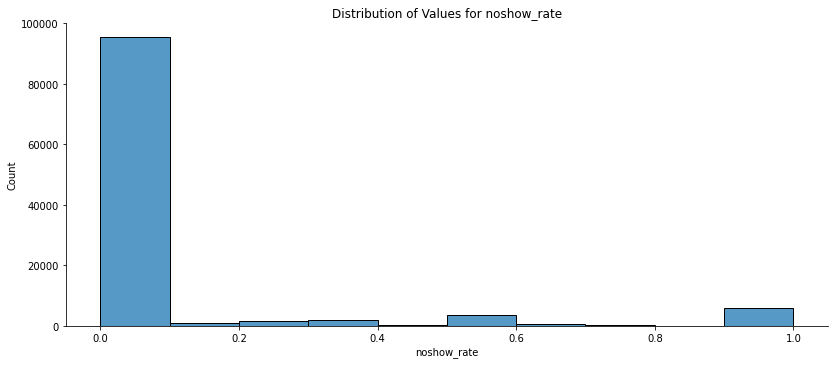

In [35]:
# Plot distribution of no-show rate
plot_dist(df_prep, 'noshow_rate', 0.1)

In [36]:
# Drop past appointments and past no-show columns
df_prep.drop(columns=['past_appts', 'past_ns'], inplace=True)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 100517 to 76224
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   pt_id             110521 non-null  float64            
 1   appt_id           110521 non-null  int64              
 2   gender            110521 non-null  object             
 3   scheduled_day     110521 non-null  datetime64[ns, UTC]
 4   appointment_day   110521 non-null  datetime64[ns, UTC]
 5   age               110521 non-null  int64              
 6   neighbourhood     110521 non-null  object             
 7   scholarship       110521 non-null  int64              
 8   hypertension      110521 non-null  int64              
 9   diabetes          110521 non-null  int64              
 10  alcoholism        110521 non-null  int64              
 11  disability_count  110521 non-null  int64              
 12  sms_received      110521 non-null  int64

#### ID Columns
I will not need the appointment ID or patient id columns past this point. Since each row represents one appointment, I can drop the appointment and patient id columns.

In [37]:
# Drop the ID columns in place
df_prep.drop(columns=['appt_id', 'pt_id'], inplace=True)

In [38]:
# Reset index due to sorting
df_prep.reset_index(drop=True, inplace=True)

In [39]:
# Print the info and view the head to verify changes
print(df_prep.info())
df_prep.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   gender            110521 non-null  object             
 1   scheduled_day     110521 non-null  datetime64[ns, UTC]
 2   appointment_day   110521 non-null  datetime64[ns, UTC]
 3   age               110521 non-null  int64              
 4   neighbourhood     110521 non-null  object             
 5   scholarship       110521 non-null  int64              
 6   hypertension      110521 non-null  int64              
 7   diabetes          110521 non-null  int64              
 8   alcoholism        110521 non-null  int64              
 9   disability_count  110521 non-null  int64              
 10  sms_received      110521 non-null  int64              
 11  no_show           110521 non-null  object             
 12  noshow_rate       110521 non-null  float64  

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate
0,F,2016-05-31 10:56:41+00:00,2016-06-03 00:00:00+00:00,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0.0
1,M,2016-06-01 14:22:58+00:00,2016-06-01 00:00:00+00:00,39,MARIA ORTIZ,0,0,1,0,0,0,No,0.0
2,F,2016-05-18 09:12:29+00:00,2016-05-18 00:00:00+00:00,33,CENTRO,0,0,0,0,0,0,No,0.0
3,M,2016-04-29 07:13:36+00:00,2016-05-02 00:00:00+00:00,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0.0
4,F,2016-04-29 07:19:57+00:00,2016-05-06 00:00:00+00:00,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0.0


### Date Feature Engineering
 
Discrete dates will not be helpful for predicting future no-shows. The day of the week that the appointment was scheduled or that the patient called to schedule may be relevant. Columns with this data will be created. The time lapse between when the appointment is made and the appointment date likely does have a relationship with no shows. A time lapse column will be created to leverage the date information.

 * Extract day of the week for `scheduled_day` and `appointment_day`
 * Create new int col for number of days between scheduled and appointment dates
 * Drop date columns

In [40]:
# What is the range of dates for the set?
df_prep['appointment_day'].agg(['min', 'max'])

min   2016-04-29 00:00:00+00:00
max   2016-06-08 00:00:00+00:00
Name: appointment_day, dtype: datetime64[ns, UTC]

In [41]:
# Could the day of the week for scheduling or the appointment day be relevant?
df_prep['appointment_weekday'] = df_prep['appointment_day'].dt.dayofweek
df_prep['scheduled_weekday'] = df_prep['scheduled_day'].dt.dayofweek

In [42]:
# Verify new columns
df_prep.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday
0,F,2016-05-31 10:56:41+00:00,2016-06-03 00:00:00+00:00,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0.0,4,1
1,M,2016-06-01 14:22:58+00:00,2016-06-01 00:00:00+00:00,39,MARIA ORTIZ,0,0,1,0,0,0,No,0.0,2,2
2,F,2016-05-18 09:12:29+00:00,2016-05-18 00:00:00+00:00,33,CENTRO,0,0,0,0,0,0,No,0.0,2,2
3,M,2016-04-29 07:13:36+00:00,2016-05-02 00:00:00+00:00,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0.0,0,4
4,F,2016-04-29 07:19:57+00:00,2016-05-06 00:00:00+00:00,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0.0,4,4


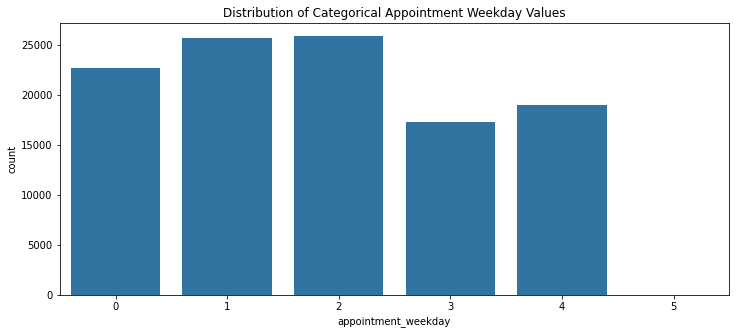

In [43]:
# Plot distribution of weekdays for appointment date
plt.subplots(figsize=fig_dims)
sns.countplot(data=df_prep, x='appointment_weekday');
plt.title('Distribution of Categorical Appointment Weekday Values');

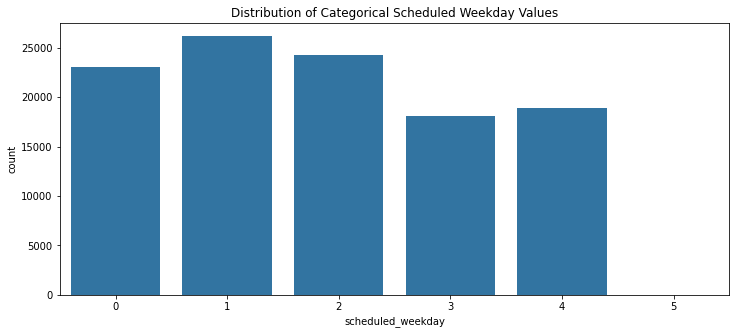

In [44]:
# Plot distribution of weekdays for scheduling date
plt.subplots(figsize=fig_dims)
sns.countplot(data=df_prep, x='scheduled_weekday');
plt.title('Distribution of Categorical Scheduled Weekday Values');

In [45]:
# Create new column for the number of days between scheduling and the actual appointment. 
df_prep['days_between'] = (df_prep['appointment_day'] - df_prep['scheduled_day']).dt.days.astype(int)

# View the statistical information about the new column.
df_prep['days_between'].describe()

count    110521.000000
mean          9.183721
std          15.255082
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64

Appointment_day does not have time included but scheduled_day does. This is causing a -1 in days_between. This value should be 0 to indicate that the appointment was scheduled on the same day. Any rows with a negative number after -1 has been replaced with 0 are erroneous and need to be removed.

In [46]:
# Replace rows with -1 for same day with 0
df_prep['days_between'].replace(-1, 0, inplace=True)

In [47]:
# Drop rows with appointment dates prior to scheduling dates
df_prep.drop(df_prep[df_prep['days_between'] < 0].index, inplace = True)

In [48]:
# Verify
df_prep['days_between'].describe()

count    110516.000000
mean          9.533190
std          15.028018
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64

In [49]:
# Drop date columns
df_prep.drop(columns=['appointment_day', 'scheduled_day'], inplace=True)
df_prep.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between
0,F,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0.0,4,1,2
1,M,39,MARIA ORTIZ,0,0,1,0,0,0,No,0.0,2,2,0
2,F,33,CENTRO,0,0,0,0,0,0,No,0.0,2,2,0
3,M,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0.0,0,4,2
4,F,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0.0,4,4,6


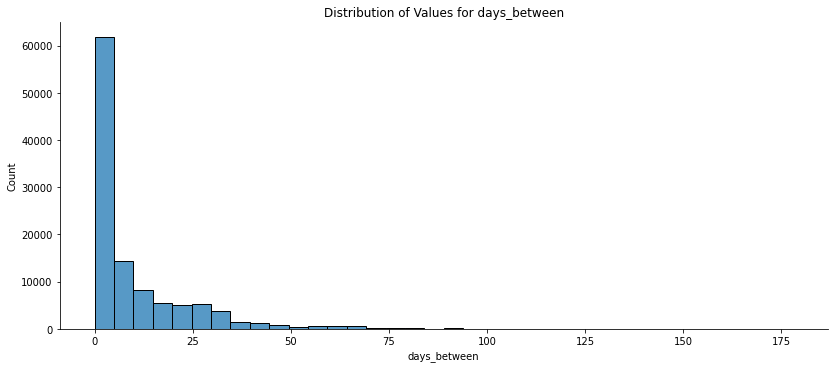

In [50]:
# Plot distribution of days between
plot_dist(df_prep, 'days_between', 5)

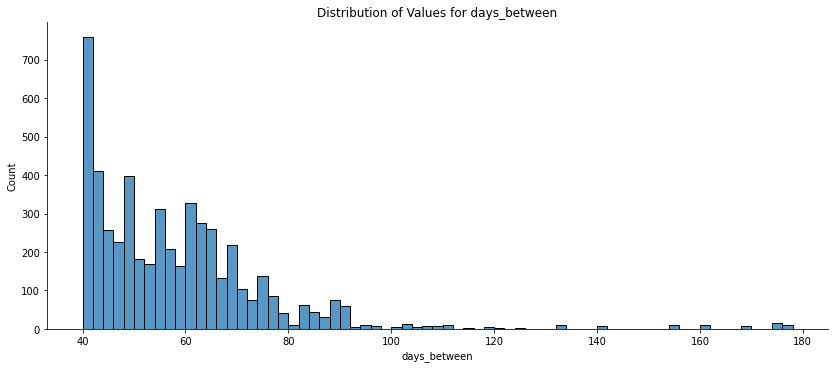

In [51]:
# Plot distribution of days between greater than approximately 2 std above the mean
plot_dist(df_prep[df_prep['days_between'] >= 40], 'days_between', 2)

In [52]:
# Copy the DataFrame for further processing
df_engineer = df_prep.copy()


#### Address Continuous Variables
`age` and `days_between` are both continuous variables with a high degree of skew. The skew will cause problems with the model, so this must be addressed. Attempts at feature scaling and transformation were unsuccessful at addressing skew for these variables due to the number of 0 values. Thus, these will be made into categorical variables through binning

**Age**

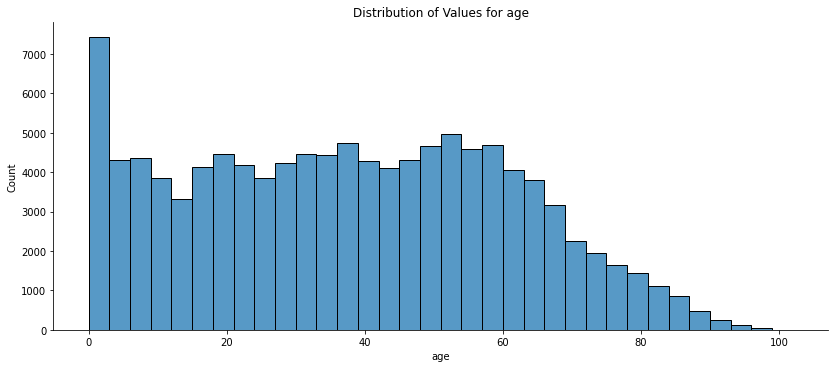

In [53]:
# View distribution of age
plot_dist(df_engineer,'age', 3)

In [54]:
# Identify the age bins and labels
age_bins = [0, 1, 5, 17, 28, 44, 54, 65, 75, 102]
age_labels = ['infant', 'preschool', 'child', 'young_adult', 'adult', 'middle_aged', 'mature_adult', 'senior', '75_and_over']
# Cut the data into bins
df_engineer['age_range'] = pd.cut(df_engineer['age'], bins=age_bins, labels=age_labels)
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between,age_range
0,F,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0.0,4,1,2,adult
1,M,39,MARIA ORTIZ,0,0,1,0,0,0,No,0.0,2,2,0,adult
2,F,33,CENTRO,0,0,0,0,0,0,No,0.0,2,2,0,adult
3,M,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0.0,0,4,2,child
4,F,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0.0,4,4,6,child


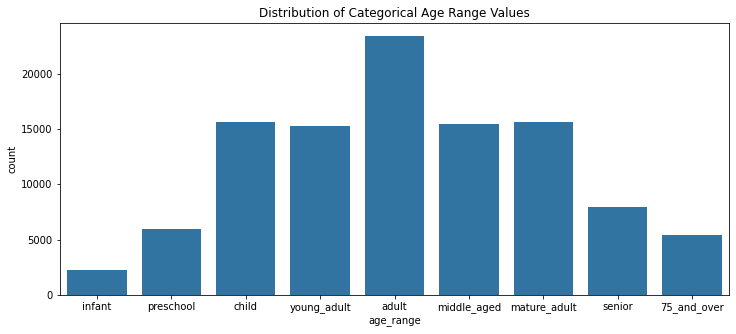

In [55]:
# Plot the distribution of the new categorical column
plt.figure(figsize=fig_dims)
sns.countplot(data=df_engineer, x='age_range');
plt.title('Distribution of Categorical Age Range Values');

**Days Between**

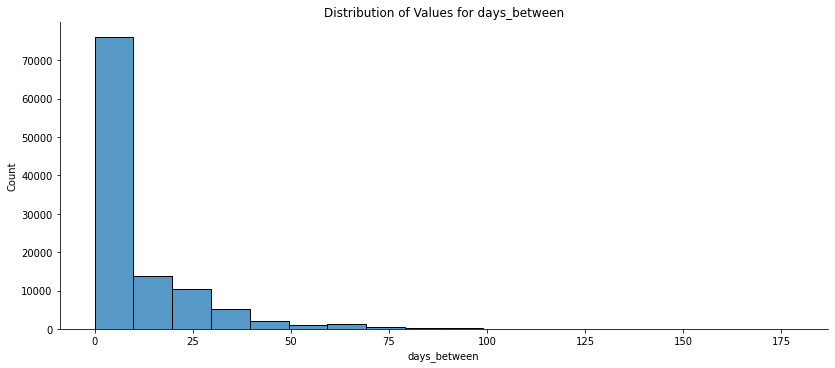

In [56]:
# Plot the distribution of the days between scheduling and the appointment date
plot_dist(df_engineer, 'days_between', 10)

In [57]:
# Define the bin cut-offs and range names
days_bins = [0, 1, 8, 31, 180]
days_labels = ['same_day', '1_to_7', '7_to_30', 'greater_than_one_month']
# Cut the data into bins
df_engineer['days_range'] = pd.cut(df_engineer['days_between'], bins=days_bins, labels=days_labels, right=False)

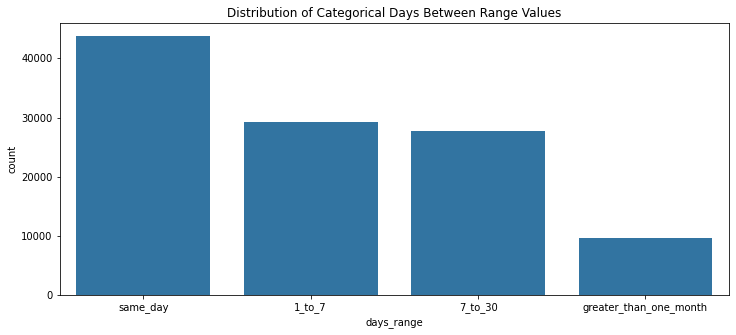

In [58]:
# Plot new distribution
plt.figure(figsize=fig_dims)
sns.countplot(data=df_engineer, x='days_range');
plt.title('Distribution of Categorical Days Between Range Values');

#### Disability Count
`disability_count` is an ordinal variable. As it is an int, no further engineering is required.


#### Categorical Variables

The rest of the variables are categorical variables. `scholarship`, `hypertension`, `diabetes`, `alcoholism`, and `sms_received` are already integer binary variables, so they require no additional engineering. `no_show` will need to be converted to a binary column. `gender`, `neighbourhood`, `age_range`, and `days_range` will need One Hot Encoding later for statistical testing.
    

In [59]:
# Review newly engineered data
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between,age_range,days_range
0,F,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,0.0,4,1,2,adult,1_to_7
1,M,39,MARIA ORTIZ,0,0,1,0,0,0,No,0.0,2,2,0,adult,same_day
2,F,33,CENTRO,0,0,0,0,0,0,No,0.0,2,2,0,adult,same_day
3,M,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,0.0,0,4,2,child,1_to_7
4,F,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,0.0,4,4,6,child,1_to_7


**Map `no_show` to binary values**

In [60]:
# Identify current no-show values
df_engineer['no_show'].unique()

array(['No', 'Yes'], dtype=object)

In [61]:
# Map no_show to binary values
df_engineer['no_show'] = df_engineer['no_show'].replace({'No': 0, 'Yes': 1})

In [62]:
# Identify updated no-show values
df_engineer['no_show'].unique()

array([0, 1], dtype=int64)

#### Visualize Relationships between existing variables
The features will have a high degree of dimensionality following One Hot Encoding and it will be difficult to review the relationships between columns. Let's look at the correlations and other relationships before One Hot Encoding.

In [63]:
# Values of correlations to no_show
df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False)

,no_show
no_show,1.000000
days_between,0.180144
sms_received,0.126552
noshow_rate,0.111385
scholarship,0.029182
scheduled_weekday,0.006024
appointment_weekday,0.001184
alcoholism,-0.000173
disability_count,-0.006594
diabetes,-0.015146


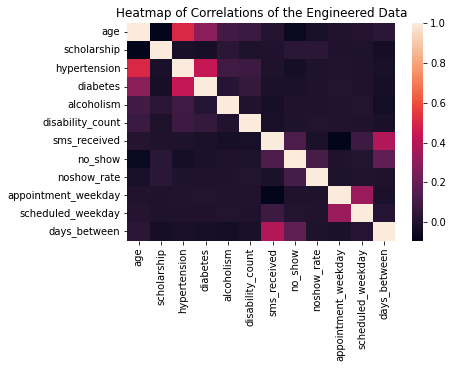

In [64]:
# Plot heatmap of correlations of updated numerical data
sns.heatmap(df_engineer.corr());
plt.title('Heatmap of Correlations of the Engineered Data');

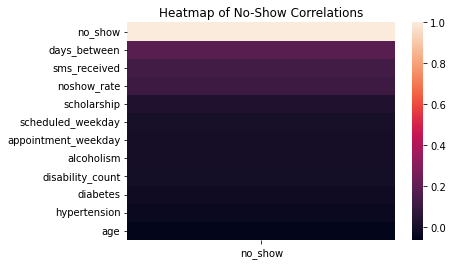

In [65]:
# Plot heatmap of correlations to no_show
sns.heatmap(df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False));
plt.title('Heatmap of No-Show Correlations');

In [66]:
# Define functions to plot updated values
def plot_proportions(df, column, ax):
    """Plots stacked barplot of proportions for a single column."""
    # Calculate proportions
    proportions = df.groupby([column, 'no_show']).size().unstack() / len(df)
    
    # Plot stacked barplot
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Set title and labels
    ax.set_title(f'Proportions of {column} No Shows')
    ax.set_xlabel('')
    ax.legend(title='No Show', labels=['no', 'yes'])

def plot_noshow(df, feature, num_cols):
    """Calls plot_proportions and creates a figure with multiple countplots of the values for each column."""
    # Number of rows
    num_rows = (len(feature) + num_cols - 1) // num_cols  
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axs = axs.flatten()
    
    for i, column in enumerate(feature):
        # Call plot_proportions function
        plot_proportions(df, column, axs[i])
    
    plt.tight_layout()

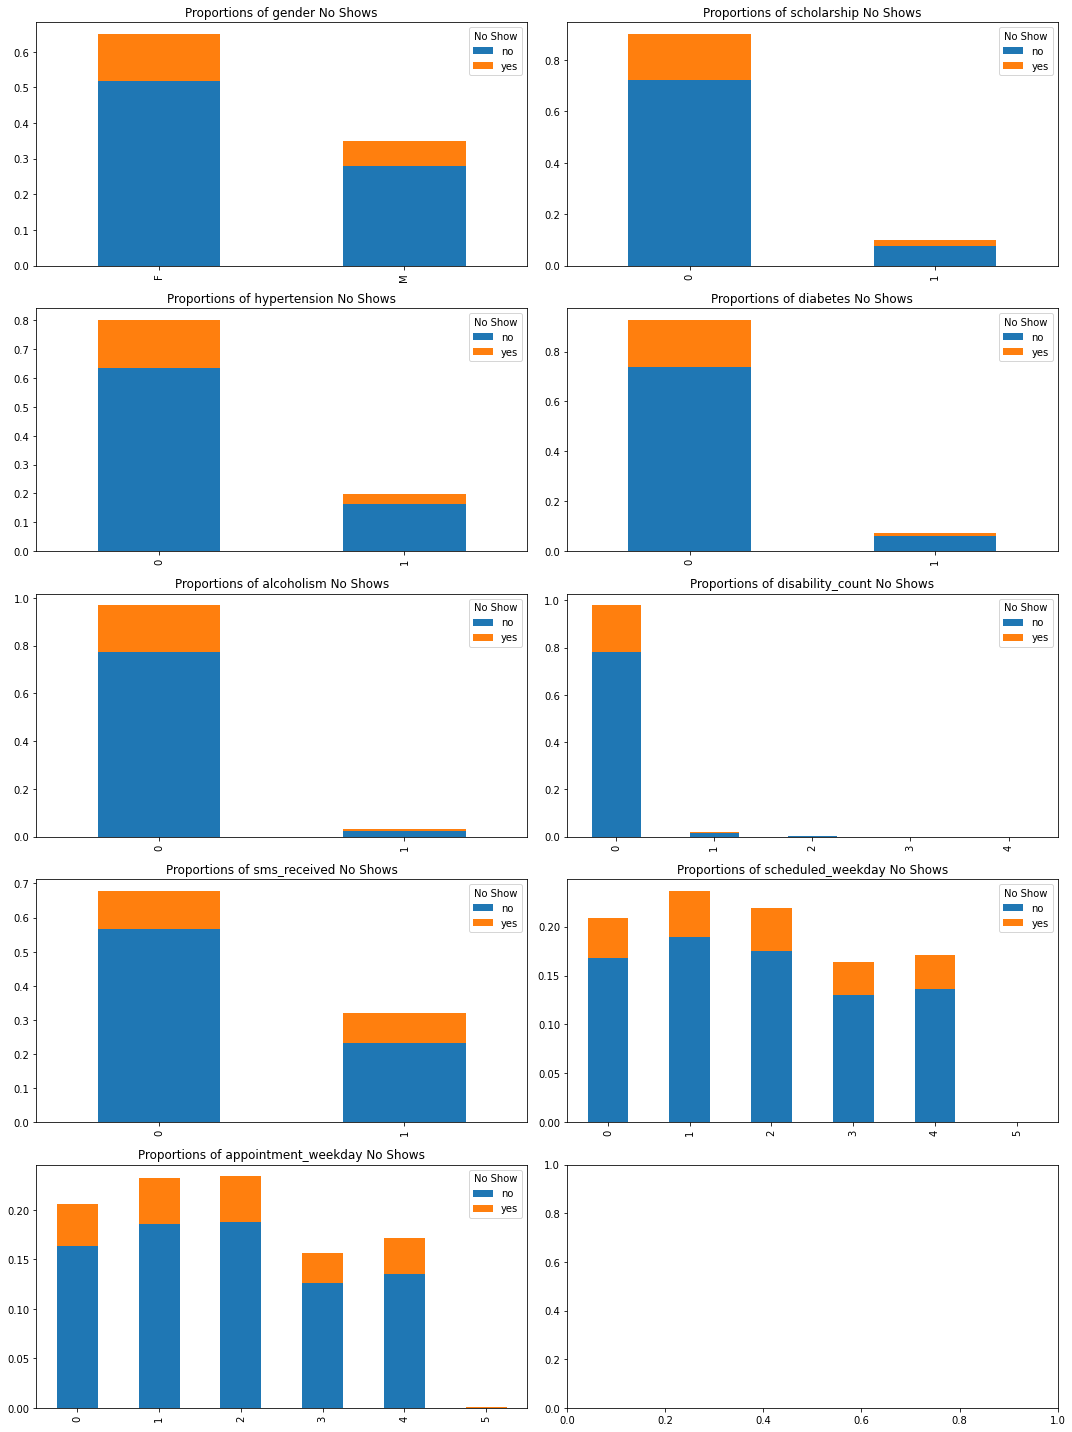

In [67]:
# Define columns that can be plotted side by side
columns_few = ['gender', 'scholarship', 'hypertension',
                         'diabetes', 'alcoholism', 'disability_count', 'sms_received',
                         'scheduled_weekday', 'appointment_weekday']
# Plot no-show proporations
plot_noshow(df_engineer, columns_few, 2)
plt.show()

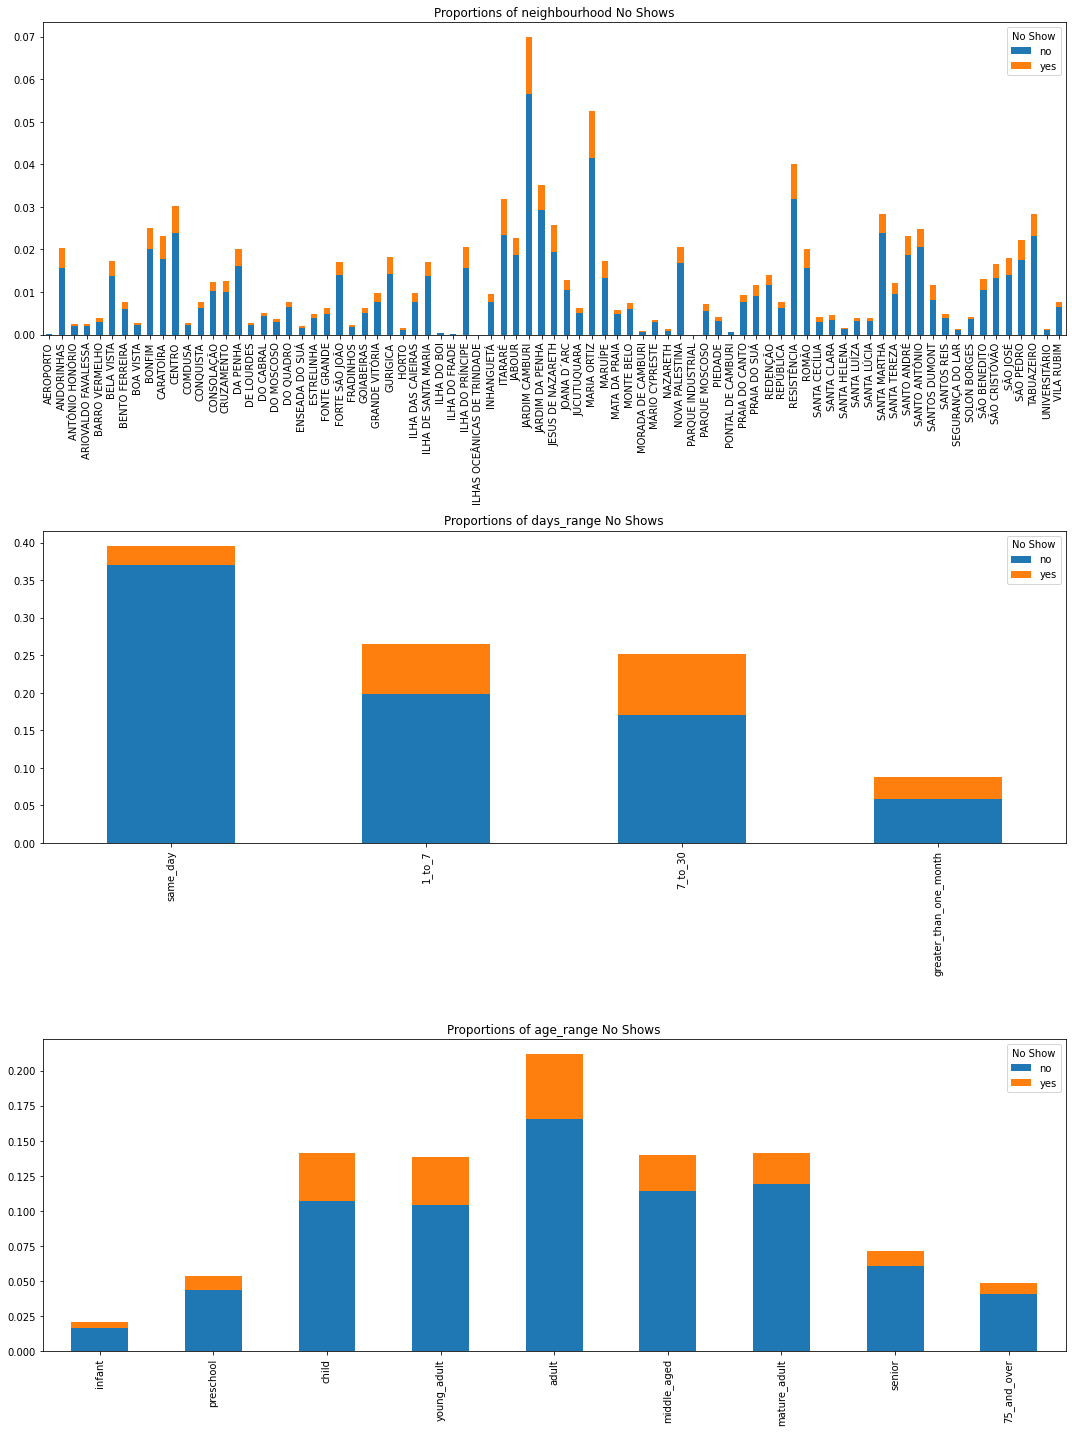

In [68]:
# Identify and plot columns with many values that need to be plotted in a single column
wide_columns = ['neighbourhood', 'days_range', 'age_range']
plot_noshow(df_engineer, wide_columns, 1)
plt.show()

### One Hot Encode multi-category columns

In [69]:
# Drop age and days_between continuous variables now that they are captured by categorical variables
df_engineer = df_engineer.drop(['age', 'days_between'], axis=1)
df_engineer.head()

,gender,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,age_range,days_range
0,F,PRAIA DO SUÁ,0,0,0,0,0,0,0,0.0,4,1,adult,1_to_7
1,M,MARIA ORTIZ,0,0,1,0,0,0,0,0.0,2,2,adult,same_day
2,F,CENTRO,0,0,0,0,0,0,0,0.0,2,2,adult,same_day
3,M,FORTE SÃO JOÃO,0,0,0,0,0,0,0,0.0,0,4,child,1_to_7
4,F,FORTE SÃO JOÃO,0,0,0,0,0,1,0,0.0,4,4,child,1_to_7


In [70]:
# One Hot Encode using get dummies for remaining categorical variables
df_engineer = pd.get_dummies(df_engineer, ['gender', 'neighbourhood', 'age_range', 'days_range'])

In [71]:
# View summary of info
df_engineer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110516 entries, 0 to 110520
Columns: 106 entries, scholarship to days_range_greater_than_one_month
dtypes: float64(1), int64(9), uint8(96)
memory usage: 23.4 MB


In [72]:
# View updated head
df_engineer.head()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_75_and_over,days_range_same_day,days_range_1_to_7,days_range_7_to_30,days_range_greater_than_one_month
0,0,0,0,0,0,0,0,0.0,4,1,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0.0,2,2,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0.0,2,2,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0.0,0,4,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0.0,4,4,...,0,0,0,0,0,0,0,1,0,0


In [73]:
# View descriptive statistics for subset of columns
df_engineer.describe()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_75_and_over,days_range_same_day,days_range_1_to_7,days_range_7_to_30,days_range_greater_than_one_month
count,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,...,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000
mean,0.098275,0.197257,0.071872,0.030403,0.022196,0.321049,0.201880,0.086549,1.858274,1.851985,...,0.138677,0.211951,0.139934,0.141409,0.071564,0.048735,0.396087,0.265138,0.250959,0.087815
std,0.297688,0.397929,0.258277,0.171694,0.161390,0.466882,0.401405,0.246985,1.371662,1.378517,...,0.345610,0.408692,0.346921,0.348445,0.257766,0.215315,0.489085,0.441409,0.433567,0.283027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection
1. Using Chi2
2. Cross validate using Pearson R


**Using Chi2**

In [74]:
# Split data into features DataFrame and label column
X = df_engineer.drop(['no_show'], axis=1)
y = df_engineer['no_show']

# Run chi2 analysis to compare the correlation of the features with the no_show label
chi_scores = chi2(X, y)

# Put results in a DataFrame for further analysis
features_chi = pd.DataFrame({'feature': list(X.columns),
                            'chi_score': chi_scores[0],
                            'p_value': chi_scores[1]})
features_chi.head()

,feature,chi_score,p_value
0,scholarship,84.867802,3.189958e-20
1,hypertension,112.633850,2.595387e-26
2,diabetes,23.530309,1.229614e-06
3,alcoholism,0.003207,9.548376e-01
4,disability_count,5.639634,1.755887e-02


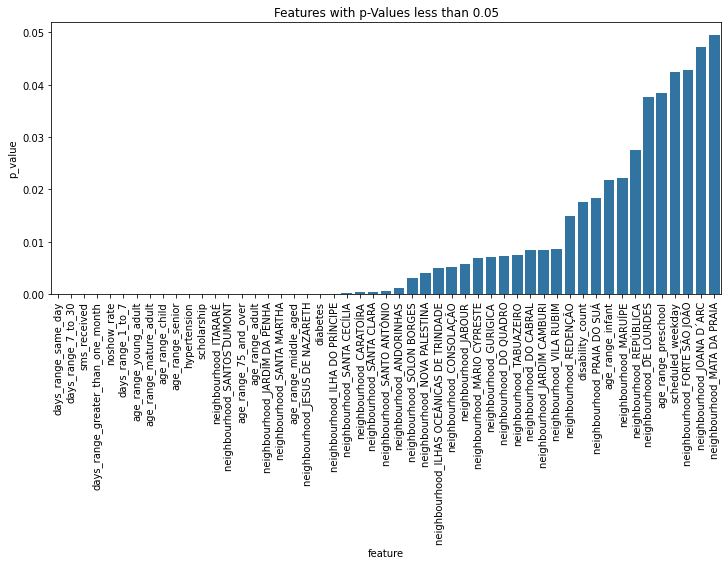

In [75]:
# Filter features based on p-value - the smaller the p, the stronger the relationship
# Start with p = 0.05
low_05p_values = features_chi.query('p_value <= 0.05').sort_values(by='p_value')

# Plot p-values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_05p_values['feature'], y=low_05p_values['p_value']);
plt.xticks(rotation='vertical');
plt.title('Features with p-Values less than 0.05');

In [76]:
# That's still a lot of features and a large number of them have p <= 0.01
low_05p_values.shape[0]

51

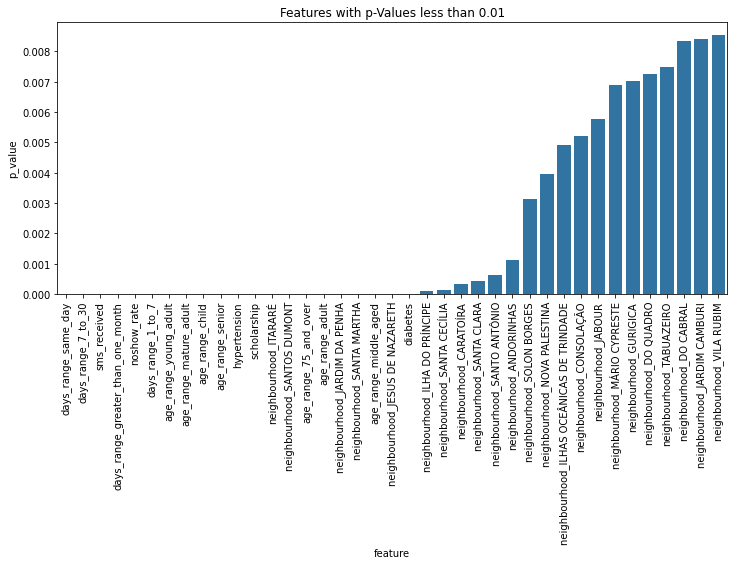

In [77]:
# On to p <= 0.01
low_p_values = features_chi.query('p_value <= 0.01').sort_values(by='p_value')

# Plot p-values <= 0.01
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_p_values['feature'], y=low_p_values['p_value']);
plt.xticks(rotation='vertical');
plt.title('Features with p-Values less than 0.01');

In [78]:
# How many features is that?
low_p_values.shape[0]

39

In [79]:
# Get list of features that will be dropped as long as the results cross validate
high_p_values = features_chi.query('p_value > 0.01')
features_to_drop = list(high_p_values['feature'])
features_to_drop

['alcoholism',
 'disability_count',
 'appointment_weekday',
 'scheduled_weekday',
 'gender_F',
 'gender_M',
 'neighbourhood_AEROPORTO',
 'neighbourhood_ANTÔNIO HONÓRIO',
 'neighbourhood_ARIOVALDO FAVALESSA',
 'neighbourhood_BARRO VERMELHO',
 'neighbourhood_BELA VISTA',
 'neighbourhood_BENTO FERREIRA',
 'neighbourhood_BOA VISTA',
 'neighbourhood_BONFIM',
 'neighbourhood_CENTRO',
 'neighbourhood_COMDUSA',
 'neighbourhood_CONQUISTA',
 'neighbourhood_CRUZAMENTO',
 'neighbourhood_DA PENHA',
 'neighbourhood_DE LOURDES',
 'neighbourhood_DO MOSCOSO',
 'neighbourhood_ENSEADA DO SUÁ',
 'neighbourhood_ESTRELINHA',
 'neighbourhood_FONTE GRANDE',
 'neighbourhood_FORTE SÃO JOÃO',
 'neighbourhood_FRADINHOS',
 'neighbourhood_GOIABEIRAS',
 'neighbourhood_GRANDE VITÓRIA',
 'neighbourhood_HORTO',
 'neighbourhood_ILHA DAS CAIEIRAS',
 'neighbourhood_ILHA DE SANTA MARIA',
 'neighbourhood_ILHA DO BOI',
 'neighbourhood_ILHA DO FRADE',
 'neighbourhood_INHANGUETÁ',
 'neighbourhood_JOANA D´ARC',
 'neighbourhood_

**Cross Validate with Pearson's R**

In [80]:
# Split data into features DataFrame and label column
Xp = df_engineer.drop(['no_show'], axis=1)
yp = df_engineer['no_show']

In [81]:
correlation_results = []
# Compute Pearson correlation coefficients and p-values for each feature
for col in Xp.columns:
    correlation, p_value = pearsonr(Xp[col], yp)
    correlation_results.append((col, correlation, p_value))

In [82]:
# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results, columns=['feature', 'r', 'p'])
correlation_df.head()

,feature,r,p
0,scholarship,0.029182,2.917332e-22
1,hypertension,-0.035631,2.179603e-32
2,diabetes,-0.015146,4.769708e-07
3,alcoholism,-0.000173,9.541363e-01
4,disability_count,-0.006594,2.836262e-02


In [83]:
# Filter df to features with p less than 0.01
low_pearsons_p = correlation_df[correlation_df['p'] <= 0.01].sort_values(by='p', ascending=True)

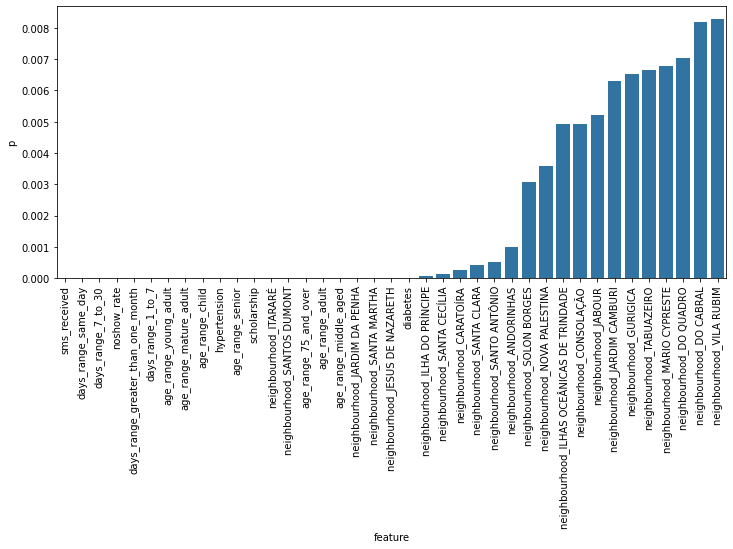

In [84]:
# Plot Pearson's Ps
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_pearsons_p['feature'], y=low_pearsons_p['p']);
plt.xticks(rotation='vertical');

In [85]:
# Count number of features with p under 0.01
low_pearsons_p.shape[0]

39

In [86]:
# Set names of selected equal to each other to validate
selection_validation = low_pearsons_p['feature'].sort_values(ascending=True) == low_p_values['feature'].sort_values(ascending=True)
selection_validation.unique()

array([ True])

### Final Feature Selection

Pearson's R and Chi2 values cross validate. These are the features that have a statistically significant relationship with no-show. 

In [87]:
# Back to review X before filtering out the columns > 0.01
X.head()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,noshow_rate,appointment_weekday,scheduled_weekday,gender_F,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_75_and_over,days_range_same_day,days_range_1_to_7,days_range_7_to_30,days_range_greater_than_one_month
0,0,0,0,0,0,0,0.0,4,1,1,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0.0,2,2,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0.0,2,2,1,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0.0,0,4,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0.0,4,4,1,...,0,0,0,0,0,0,0,1,0,0


In [88]:
# Dropping the identified features from X
X.drop(columns=features_to_drop, inplace=True)
X.head()

,scholarship,hypertension,diabetes,sms_received,noshow_rate,neighbourhood_ANDORINHAS,neighbourhood_CARATOÍRA,neighbourhood_CONSOLAÇÃO,neighbourhood_DO CABRAL,neighbourhood_DO QUADRO,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_75_and_over,days_range_same_day,days_range_1_to_7,days_range_7_to_30,days_range_greater_than_one_month
0,0,0,0,0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [89]:
# Duplicating df_engineer and dropping identified features to have DataFrame for visualizations that contain no_show
selected_df = df_engineer.copy()
selected_df.drop(columns=features_to_drop, inplace=True)
selected_df.head()

,scholarship,hypertension,diabetes,sms_received,no_show,noshow_rate,neighbourhood_ANDORINHAS,neighbourhood_CARATOÍRA,neighbourhood_CONSOLAÇÃO,neighbourhood_DO CABRAL,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_75_and_over,days_range_same_day,days_range_1_to_7,days_range_7_to_30,days_range_greater_than_one_month
0,0,0,0,0,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0.0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0.0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<a id='model'></a>
## Model

Objective 4: Train and Tune machine learning models

### Step 1: Split the data

In [90]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Transformed Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Transformed Training set has 88412 samples.
Testing set has 22104 samples.


### Step 2: Naive Predictor

Fit and Predict the Naive Predictor using the uniform strategy as it provides a baseline with no knowledge of the class distribution.

In [91]:
# Calculate the naive predictor
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42).fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_test)
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, dummy_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, dummy_preds, beta = 2)))

Accuracy score on testing data: 0.7992
F2-score on testing data: 0.0000


### Step 3: Instantiate the Classifiers

In [92]:
# instantiate models
naive_bayes = MultinomialNB()
rf_mod = RandomForestClassifier(random_state=42)
tree_mod = DecisionTreeClassifier(random_state=42)
kneigh_mod = KNeighborsClassifier()

### Step 4: Train and Predict

In [93]:
# train models
naive_bayes.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)
tree_mod.fit(X_train, y_train)
kneigh_mod.fit(X_train, y_train)

KNeighborsClassifier()

In [94]:
# predict results
nb_preds = naive_bayes.predict(X_test)
rf_preds = rf_mod.predict(X_test)
tree_preds = tree_mod.predict(X_test)
k_preds = kneigh_mod.predict(X_test)

### Step 4: Select Models for Tuning

In [95]:
# Naive Bayes Classification
print(classification_report(y_test, nb_preds))
print(confusion_matrix(y_test, nb_preds))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, nb_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, nb_preds, beta = 2)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17666
           1       0.48      0.04      0.07      4438

    accuracy                           0.80     22104
   macro avg       0.64      0.51      0.48     22104
weighted avg       0.74      0.80      0.72     22104

[[17482   184]
 [ 4268   170]]
Accuracy score on testing data: 0.7986
F2-score on testing data: 0.0469


In [96]:
# Random Forest
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, rf_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, rf_preds, beta = 2)))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     17666
           1       0.42      0.11      0.17      4438

    accuracy                           0.79     22104
   macro avg       0.62      0.54      0.53     22104
weighted avg       0.73      0.79      0.74     22104

[[17017   649]
 [ 3959   479]]
Accuracy score on testing data: 0.7915
F2-score on testing data: 0.1269


In [97]:
# Decision Tree Classifier
print(classification_report(y_test, tree_preds))
print(confusion_matrix(y_test, tree_preds))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, tree_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, tree_preds, beta = 2)))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     17666
           1       0.42      0.10      0.16      4438

    accuracy                           0.79     22104
   macro avg       0.61      0.53      0.52     22104
weighted avg       0.73      0.79      0.74     22104

[[17066   600]
 [ 4006   432]]
Accuracy score on testing data: 0.7916
F2-score on testing data: 0.1150


In [98]:
# K-Neighbors Classifier
print(classification_report(y_test, k_preds))
print(confusion_matrix(y_test, k_preds))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, k_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, k_preds, beta = 2)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     17666
           1       0.34      0.21      0.26      4438

    accuracy                           0.76     22104
   macro avg       0.58      0.55      0.56     22104
weighted avg       0.72      0.76      0.74     22104

[[15925  1741]
 [ 3523   915]]
Accuracy score on testing data: 0.7619
F2-score on testing data: 0.2242


K-Neighbors and Random Forest have the best overall scores across the board. I will determine if any additional improvements can be made through tuning these models before making a final selection.

### Step 6: Model Tuning


In [99]:
# Try tuning Random Forest using cross validation
forest = RandomForestClassifier(random_state=42)

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=2)

# parameter grid
parameters = {'max_depth': [3, None],
              'n_estimators': list(range(10, 200)),
              'max_features': list(range(1, X_test.shape[1]+1)),
              'min_samples_split': list(range(2, 11)),
              'min_samples_leaf': list(range(1, 11)),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

# Perform randomized search on the classifier using 'scorer' as the scoring method 
random_forest_obj = RandomizedSearchCV(forest, parameters, scoring=scorer)

# Fit the randomized search object to the training data and find the optimal parameters using fit()
forest_fit = random_forest_obj.fit(X_train, y_train)

# Get the estimator
best_forest = forest_fit.best_estimator_

In [100]:
# Identify best parameters
forest_fit.best_params_

{'n_estimators': 79,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 9,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [101]:
# Run predictions on tuned model
forest_preds = best_forest.predict(X_test)

In [102]:
# Try tuning K-Neighbors using cross validation
kn_random = KNeighborsClassifier()

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=2)

# Parameter grid
parameters = {'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 50, 100, 500, 1000],
              }

# Perform randomized search on the classifier using 'scorer' as the scoring method
random_kn_obj = RandomizedSearchCV(kn_random, parameters, scoring=scorer)

# Fit the randomized search object to the training data and find the optimal parameters using fit()
kn_fit = random_kn_obj.fit(X_train, y_train)

# Get the estimator
best_kn = kn_fit.best_estimator_

In [103]:
# Identify best parameters
kn_fit.best_params_

{'weights': 'distance', 'leaf_size': 100, 'algorithm': 'brute'}

In [104]:
# Run predictions on tuned model
kn_preds = best_kn.predict(X_test)

### Step 7: Prepare Metrics for Final Analysis

In [105]:
# Print final metrics for Random Forest model
print("Random Forest")
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, rf_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, rf_preds, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, forest_preds)))
print("Final F2-score on the testing data: {:.4f}".format(fbeta_score(y_test, forest_preds, beta = 2)))

Random Forest
Unoptimized model
------
Accuracy score on testing data: 0.7915
F2-score on testing data: 0.1269

Optimized Model
------
Final accuracy score on the testing data: 0.8001
Final F2-score on the testing data: 0.1030


In [106]:
# Print final metrics for K Neighbors model
print("K Neighbors")
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, k_preds)))
print("F2-score on testing data: {:.4f}".format(fbeta_score(y_test, k_preds, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, kn_preds)))
print("Final F2-score on the testing data: {:.4f}".format(fbeta_score(y_test, kn_preds, beta = 2)))

K Neighbors
Unoptimized model
------
Accuracy score on testing data: 0.7619
F2-score on testing data: 0.2242

Optimized Model
------
Final accuracy score on the testing data: 0.7603
Final F2-score on the testing data: 0.2260


### Conclusions about Trained and Tuned Models

For the Random Forest Classifier, the unoptimized model actually performs better on the Fbeta score than the optimized model, so the pre-tuning model will be used for final comparisons. The pre-tuning trained model is represented by rf_mod and the predictions are rf_preds.

The optimized K-Neighbors model performs slightly better on the Fbeta score and will be used.

The Accuracy Score for the Random Forest model is higher than that of the K-Neighbors model, but the Fbeta score of the K-neighbors model is higher than that of the Random Forest model. For this reason, both models will be compared to the naive predictor.

<a id='assess'></a>
## Assess
Objective 5: Finalize analysis of model and features


In [107]:
print("Naive Predictor")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, dummy_preds)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, dummy_preds, beta = 2)))
print()
print("Random Forest Classifier")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, rf_preds)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, rf_preds, beta = 2)))
print()
print("K-Neighbors Classifier")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, kn_preds)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, kn_preds, beta = 2)))

Naive Predictor
Accuracy score on testing data: 0.7992
F-score on testing data: 0.0000

Random Forest Classifier
Accuracy score on testing data: 0.7915
F-score on testing data: 0.1269

K-Neighbors Classifier
Accuracy score on testing data: 0.7603
F-score on testing data: 0.2260


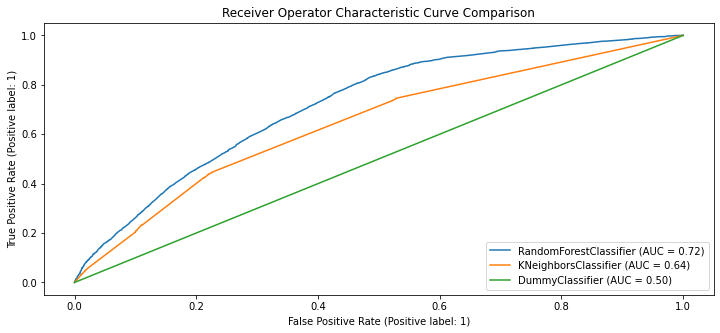

In [108]:
# Plot ROC Curve with AUC Score
fig,ax = plt.subplots(figsize=fig_dims)
RocCurveDisplay.from_estimator(best_forest, X_test, y_test, ax=ax);
RocCurveDisplay.from_estimator(best_kn, X_test, y_test, ax=ax);
RocCurveDisplay.from_estimator(dummy_model, X_test, y_test, ax=ax);
plt.title('Receiver Operator Characteristic Curve Comparison');

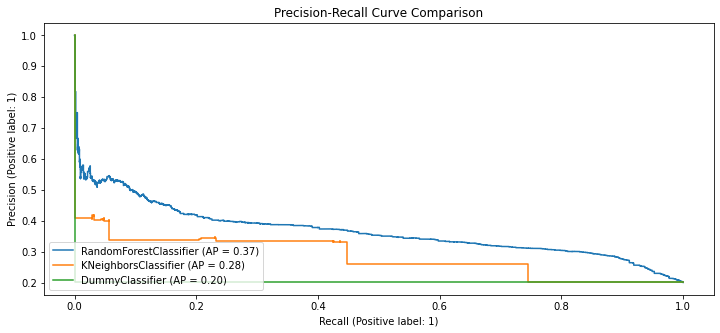

In [109]:
# Plot Precision-Recall Curve with AUC Score
fig,ax = plt.subplots(figsize=fig_dims)
PrecisionRecallDisplay.from_estimator(best_forest, X_test, y_test, ax=ax);
PrecisionRecallDisplay.from_estimator(best_kn, X_test, y_test, ax=ax);
PrecisionRecallDisplay.from_estimator(dummy_model, X_test, y_test, ax=ax);
plt.title('Precision-Recall Curve Comparison');

**Feature Importances**

In [110]:
# Retrieve feature importances
importances = rf_mod.feature_importances_

# Sort features based on importance scores
sorted_indices = importances.argsort()[::-1]  # Sort in descending order

# Print feature importances
for idx in sorted_indices:
    print(f"Feature: {X_train.columns[idx]}, Importance: {importances[idx]}")

Feature: noshow_rate, Importance: 0.19854538012196674
Feature: days_range_same_day, Importance: 0.1899194582988508
Feature: days_range_7_to_30, Importance: 0.0622937873354791
Feature: sms_received, Importance: 0.052616499114460966
Feature: scholarship, Importance: 0.03423839865059059
Feature: hypertension, Importance: 0.03071125420405358
Feature: days_range_1_to_7, Importance: 0.029338352666842166
Feature: diabetes, Importance: 0.02902852069978258
Feature: days_range_greater_than_one_month, Importance: 0.028435105731921585
Feature: age_range_adult, Importance: 0.01940085426666344
Feature: age_range_child, Importance: 0.019119632468364373
Feature: age_range_mature_adult, Importance: 0.017397276339560917
Feature: age_range_middle_aged, Importance: 0.016689419733575423
Feature: age_range_young_adult, Importance: 0.016596981983680828
Feature: neighbourhood_JARDIM CAMBURI, Importance: 0.016253543818726016
Feature: neighbourhood_CARATOÍRA, Importance: 0.015229982918086915
Feature: neighbourh

In [111]:
# Create a DataFrame of thefeatures and their importances
important_features = pd.DataFrame({'feature': X_train.columns[sorted_indices],
                                   'importance': importances[sorted_indices]})

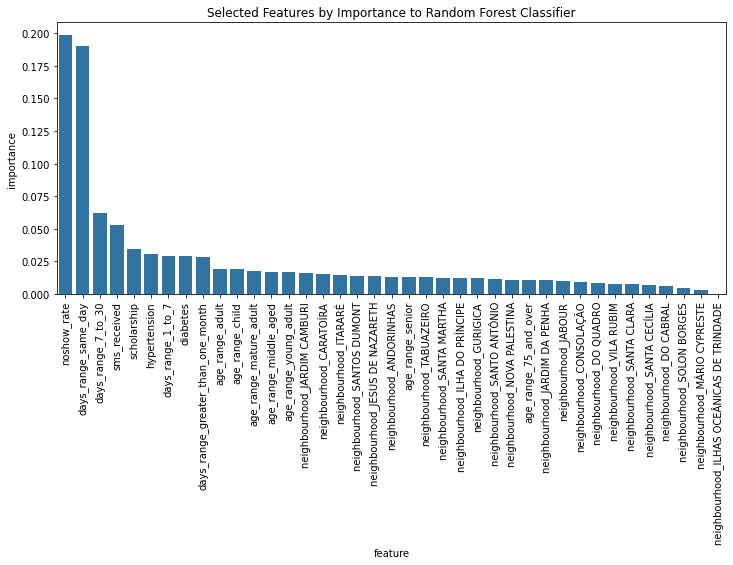

In [112]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=important_features['feature'], y=important_features['importance']);
plt.xticks(rotation='vertical');
plt.title('Selected Features by Importance to Random Forest Classifier');

<a id='conclusions'></a>
## Conclusions

### Statistical and Practical Significance

The null hypothesis for this project was as follows:
H0: A machine learning model will not be able to improve upon the combined performance of the Naïve Predictor for accuracy, Fβ score, and AUC scores to identify patients at risk of no-showing for appointments.
H1: A machine learning model will be able to improve upon the combined performance of the Naïve Predictor for accuracy, Fβ score, and AUCs score to identify patients at risk of no-showing for appointments.
Reviewing the combined scores of the Random Forest model and the Naïve Predictor shows that the null hypothesis can be rejected.
The F2, ROC AUC, and Precision-Recall AUC scores for the Random Forest model were higher than those of the Naïve Predictor. They provide a good deal of information about the model’s ability to predict the minority class, where patients no-showed for their appointments. The accuracy score of the Random Forest model is slightly lower than that of the Naïve Predictor; however, the Naïve Predictor is trained with the most frequent method, where the majority class is used as the prediction for all labels and the minority class is classified incorrectly 100% of the ti

Interventions for patient appointment no-shows can range in cost and human effort. Automated reminders may have the lowest human effort, but they can also be costly. Staffing for individualized interventions, such as patient navigators, may be effective but it is also expensive and resource intensive (Oikonomidi et al., 2022).
As Oikonomidi et al. (2022) found in their rapid systematic review of studies, intervention to prevent patient no-shows that are applied on the basis of predictive models are widely being studied and can reduce no-show rates. Xiruo et al. (2018) identified that the effectiveness of predictive models can vary greatly, even within the context of a single health system. As the importance of patient and clinic characteristics can vary across different specialties, models must be developed and analyzed in a context specific manner. 
As the optimized model performs better than the Naïve Predictor and the null hypothesis was rejected, the model can be used to help with decision making about where to apply resources to decrease patient no-shows
me. 


<a id='sources'></a>
## Sources
**References**

All, M. (2022). Supervised Machine Learning. datacamp. https://www.datacamp.com/blog/supervised-machine-learning

Bolsa Familia (2024, January 15). In Wikipedia, The Free Encyclopedia. Retrieved 18:10, February 25, 2024, from https://en.wikipedia.org/w/index.php?title=Bolsa_Fam%C3%ADlia&oldid=1195888078

Brownlee, J. (2019). How to Develop and Evaluate Naïve Classifier Strategies using Probability. https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/#:~:text=A%20naive%20classifier%20model%20is,order%20to%20make%20a%20prediction

Brownlee, J. (2023). How to Use ROC Curves and Precision-Recall Curves for Classification in Python. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Carreras-García, D., Delgado-Gómez, D., Llorente-Fernández, F., & Arribas-Gil, A. (2020). Patient No-Show Prediction: A Systematic Literature Review. Entropy (Basel, Switzerland), 22(6), 675. https://doi.org/10.3390/e22060675

Data Science Methodologies and Frameworks Guide. Data Science Process Alliance. (2022, June 1). https://www.datascience-pm.com/data-science-methodologies/

Deina, C., Fogliatto, F.S., da Silveira, G.J.C., & Anzanello, M.J. (2024). Decision analysis framework for predicting no-shows to appointments using machine learning algorithms. BMC Health Services Research 24, 37 (2024). https://doi.org/10.1186/s12913-023-10418-6

Geifman, N., Cohen, R., & Rubin, E. Redefining meaningful age groups in the context of disease. Age (Dordr). 2013 Dec;35(6):2357-66. doi: 10.1007/s11357-013-9510-6. Epub 2013 Jan 27. PMID: 23354682; PMCID: PMC3825015. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3825015/

Hoppen, J. (2016) Medical Appointment No Shows. Kaggle. https://www.kaggle.com/datasets/joniarroba/noshowappointments

Hotz, N. (2023). What is SEMMA? Data Science Process Alliance. https://www.datascience-pm.com/semma/

Marbouh, D., Khaleel, I., Al Shanqiti, K., Al Tamimi, M., Simsekler, M. C. E., Ellahham, S., Alibazoglu, D., & Alibazoglu, H. (2020). Evaluating the Impact of Patient No-Shows on Service Quality. Risk management and healthcare policy, 13, 509–517. https://doi.org/10.2147/RMHP.S232114

Oikonomidi, T., Norman, G., McGarrigle, L., Stokes, J., van der Veer, S., & Dowding, D. (2023). Predictive model-based interventions to reduce outpatient no-shows: a rapid systematic review, Journal of the American Medical Informatics Association, Volume 30, Issue 3, March 2023, Pages 559–569, https://doi.org/10.1093/jamia/ocac242

Trevisan, V. (2022). Interpreting ROC Curve and ROC AUC for Classification Evaluation: How I wish I was taught ROC Curve when I first learned it. Towards Data Science. https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077

Xiruo D., Gellad, Z. F., Mather, C., Barth, P., Poon, E. G., Newman, M. & Goldstein, B. A. (2018) Designing risk prediction models for ambulatory no-shows across different specialties and clinics, Journal of the American Medical Informatics Association, 25(8), 924-930, https://doi.org/10.1093/jamia/ocy002


**Coding Sources**

For Machine Learning:
https://www.geeksforgeeks.org/box-cox-transformation-using-python/
https://robjhyndman.com/hyndsight/transformations/https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/
https://towardsdatascience.com/instance-hardness-threshold-an-undersampling-method-to-tackle-imbalanced-classification-problems-6d80f91f0581
https://www.youtube.com/watch?v=iJ5c-XoHPFo&t=1049s
https://www.youtube.com/watch?v=vxdVKbAv6as&t=1s
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCVhttps://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifierhttps://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier
https://machinelearningmastery.com/calculate-feature-importance-with-python/
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.htmlhttps://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
https://www.evidentlyai.com/classification-metrics/explain-roc-curve#:~:text=ROC%20AUC%20score%20shows%20how,have%20an%20AUC%20of%200.5.https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay.from_predictions
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ion-in-python/